In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# adfuller test
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)  # p<0.05, Stationary

In [3]:
ten_stocks_close = pd.read_csv('close_df.csv')

In [4]:
pool = ["600094.XSHG",    
        "600160.XSHG", 
        "600008.XSHG",
        "600903.XSHG",
        "000959.XSHE",
        "600970.XSHG",
        "002302.XSHE",
        "600823.XSHG",
        "002503.XSHE",
        "600664.XSHG"]

In [5]:
close_price = ten_stocks_close['600008.XSHG']

## Ljung Box Test on close price

In [6]:
import statsmodels.api as sm
sm.stats.acorr_ljungbox(close_price, lags=[12], return_df=True) # The p-value closes to 0. Has dependency

,lb_stat,lb_pvalue
12,15014.177971,0.0


## Stationarity on close price first

In [7]:
test_stationarity(close_price) # p-value is larger than 0.05. Has unit root

Results of Dickey-Fuller Test:
Test Statistic                   -2.635510
p-value                           0.085878
#Lags Used                        8.000000
Number of Observations Used    1417.000000
Critical Value (1%)              -3.434973
Critical Value (5%)              -2.863582
Critical Value (10%)             -2.567857
dtype: float64


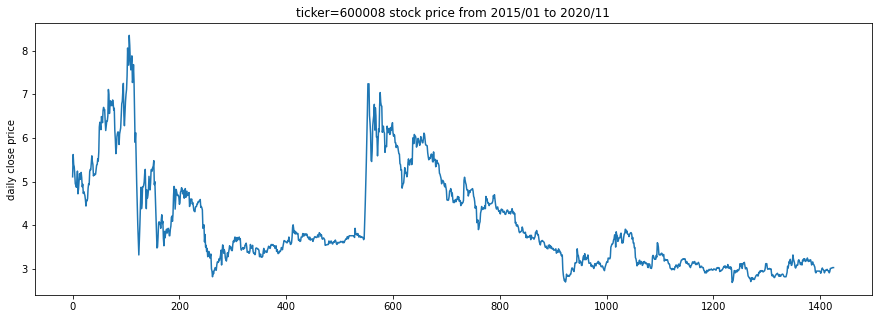

In [8]:
# visualize daily close data, lable y = column 1, ticker = 600094
close_price.plot(figsize=(15,5))
plt.ylabel('daily close price')
plt.title('ticker=600008 stock price from 2015/01 to 2020/11')
plt.show()

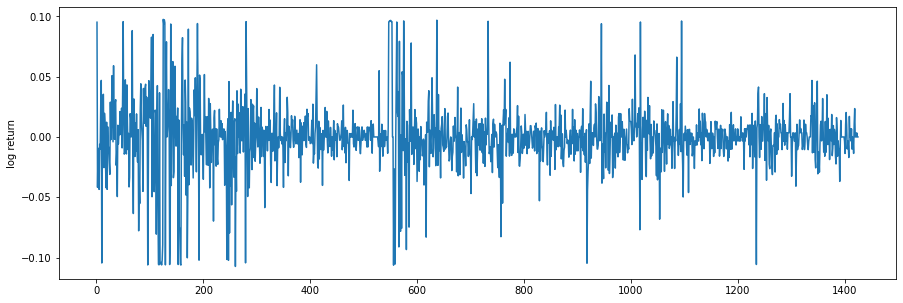

In [9]:
log_rtn = np.log(close_price).diff(1).dropna()
log_rtn.plot(figsize=(15,5))
plt.ylabel('log return')
plt.show()

## Test stationarity

In [10]:
test_stationarity(log_rtn) #p-value is small, it's stationary

Results of Dickey-Fuller Test:
Test Statistic                -1.630897e+01
p-value                        3.210281e-29
#Lags Used                     5.000000e+00
Number of Observations Used    1.419000e+03
Critical Value (1%)           -3.434967e+00
Critical Value (5%)           -2.863579e+00
Critical Value (10%)          -2.567856e+00
dtype: float64


## ACF & PACF

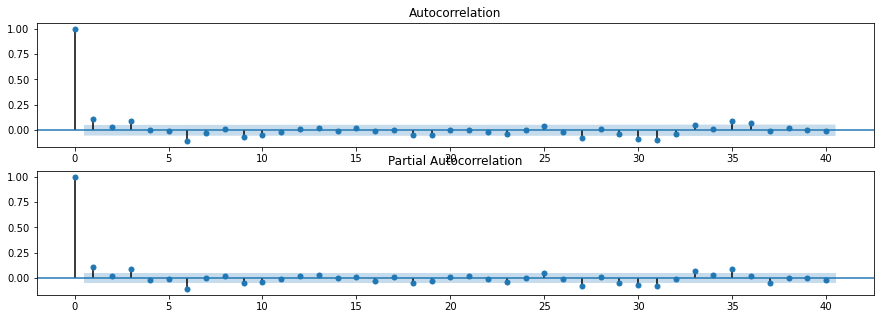

In [11]:
# acf & pacf for log return
import statsmodels.api as sm
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_rtn, lags=40, ax=ax1) 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_rtn, lags=40, ax=ax2)

## Distribution of log return

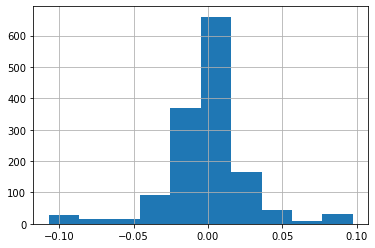

In [12]:
log_rtn.hist()
plt.show()

## Fit ARMA Model

In [13]:
import pandas as pd
import itertools
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima_model import ARIMA

p = range(7)
q = range(7)

combinations = list(itertools.product(p, q))
combinations = combinations[1:] # Drop (0,0)
def train_ARMA(param):
    try:
        p = param[0]
        q = param[1]
        model = ARIMA(log_rtn, order=(p,0,q))

        model_fit = model.fit(disp=0)

        ljung_p = sm.stats.acorr_ljungbox(model_fit.resid, lags=[12-p-q], return_df=True).values[0][1]
        aic = model_fit.aic
        return {'p': p, 'q': q, 'ljung_p': ljung_p, 'aic': aic}
    except:
        print(param)

results = pd.DataFrame(columns=['p', 'q', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_ARMA(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(3, 5)
(3, 6)
(4, 5)
(4, 6)
(5, 5)
(5, 6)
(6, 6)


,p,q,ljung_p,aic
30,6.0,4.0,0.999005,-6214.791245
31,6.0,5.0,0.850995,-6213.280002
26,6.0,0.0,0.999908,-6213.079819
27,6.0,1.0,0.999785,-6211.082442
28,6.0,2.0,0.999906,-6210.663967
5,0.0,6.0,0.999976,-6210.061514
29,6.0,3.0,0.999883,-6209.801625
24,5.0,3.0,0.980799,-6209.686118
20,4.0,4.0,0.950953,-6206.410869
25,5.0,4.0,0.971002,-6205.953316


## GARCH

In [14]:
mean = log_rtn.mean() # The mean closes to 0

### Check if volatility time dependency

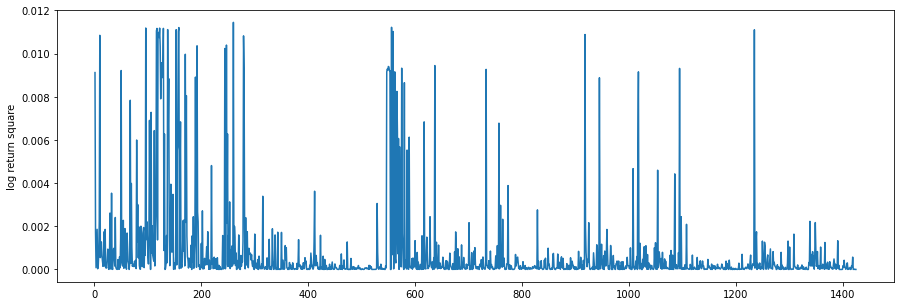

In [15]:
#log return square 
log_rtn_square = np.square(log_rtn-mean)
log_rtn_square.plot(figsize=(15,5))
plt.ylabel('log return square')
plt.show()

In [16]:
import statsmodels.api as sm

p_2 = sm.stats.acorr_ljungbox(log_rtn_square, lags=[40], return_df=True)['lb_pvalue'].values[0] # log return square is white noise if p < 0.05

print(f"P-value for squared log return: {p_2}")
if (p_2<0.05):
    print("Conclusion: Has ARCH's property in log rtn")
else:
    print("Conclusion: No ARCH's property in log rtn")

P-value for squared log return: 0.0
Conclusion: Has ARCH's property in log rtn


In [17]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_GARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, mean='constant', p=p, q=q)
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    
    return {'p':p, 'q': q, 'alpha': res.params['alpha[1]'], 'beta': res.params['beta[1]'], 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'alpha', 'beta', 'ljung_p', 'aic'])
for pq in combinations:
    results = results.append(train_GARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3388.969516983504
            Iterations: 2
            Function evaluations: 26
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3391.5866767355114
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3388.423763094257
            Iterations: 6
            Function evaluations: 21
            Gradient evaluations: 2
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3384.063062051133
            Iterations: 15
            Function evaluations: 126
            Gradient evaluations: 11
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3385.142020092162
            Iterations: 3
            Function evaluati

,p,q,alpha,beta,ljung_p,aic
1,1.0,2.0,0.100000,0.440000,0.362604,-6773.173353
0,1.0,1.0,0.100000,0.880000,0.435505,-6769.939034
6,3.0,1.0,0.078410,0.899733,0.357924,-6768.185148
2,1.0,3.0,0.100000,0.293333,0.284773,-6764.847526
4,2.0,2.0,0.050000,0.440000,0.249159,-6758.284040
3,2.0,1.0,0.052792,0.877414,0.352861,-6758.126124
5,2.0,3.0,0.050000,0.293333,0.184496,-6748.578630
7,3.0,2.0,0.033335,0.439999,0.187120,-6748.185722
8,3.0,3.0,0.033333,0.293330,0.131063,-6739.435707


## EGARCH

In [18]:
from arch.univariate import arch_model
import itertools
import warnings
warnings.filterwarnings("ignore")

p = range(1,4)
q = range(1,4)

combinations = list(itertools.product(p, q))

def train_EGARCH(param):
    p = param[0]
    q = param[1]
    model = arch_model(log_rtn, vol='EGARCH', mean='constant', p=p, q=q, dist='t')
    
    res = model.fit(update_freq=0)
    
    ljung_p = sm.stats.acorr_ljungbox(res.std_resid, lags=[12], return_df=True).values[0][1]
    aic = res.aic
    return {'p':p, 'q': q, 'params': res.params, 'ljung_p': ljung_p, 'aic': aic}

results = pd.DataFrame(columns=['p', 'q', 'params', 'ljung_p', 'aic'])

for pq in combinations:
    results = results.append(train_EGARCH(pq), ignore_index=True) 

results[results['ljung_p']>=0.05].sort_values(by=['aic'])

Optimization terminated successfully    (Exit mode 0)
            Current function value: -3563.097822133718
            Iterations: 18
            Function evaluations: 134
            Gradient evaluations: 18
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3563.833139781572
            Iterations: 20
            Function evaluations: 169
            Gradient evaluations: 20
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3563.917448628562
            Iterations: 19
            Function evaluations: 181
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3563.97886428788
            Iterations: 19
            Function evaluations: 165
            Gradient evaluations: 19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3564.9352884473683
            Iterations: 32
            Function

,p,q,params,ljung_p,aic
0,1,1,mu -0.000189 omega -0.047737 alph...,0.458629,-7116.195644
3,2,1,mu -0.000180 omega -0.037819 alph...,0.464858,-7115.957729
4,2,2,mu -0.000156 omega -0.087099 alph...,0.565278,-7115.870577
1,1,2,mu -0.000185 omega -0.053845 alph...,0.483580,-7115.666280
7,3,2,mu -0.000157 omega -0.079485 alph...,0.558593,-7114.178462
6,3,1,mu -0.000173 omega -0.036300 alph...,0.452743,-7114.063919
5,2,3,mu -1.567737e-04 omega -9.165013e...,0.564078,-7114.006300
2,1,3,mu -0.000184 omega -0.053824 alph...,0.460093,-7113.834897
8,3,3,mu -2.060763e-04 omega -1.082484e...,0.441674,-7110.901711
